## As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

## In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

## Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

## Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

## Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

# Imports

In [1]:
import pandas as pd

from env import user, password, host

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
query = """
            
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
FROM properties_2017

LEFT JOIN propertylandusetype USING(propertylandusetypeid)

WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential")"""
    
df = pd.read_sql(query, url)
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
...,...,...,...,...,...,...,...
2152859,4.0,3.0,2262.0,960756.0,2015.0,13494.52,6059.0
2152860,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0
2152861,0.0,0.0,NaN,208057.0,NaN,5783.88,6059.0
2152862,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


## Do I like the column names?

In [3]:
# check the column names
df.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips'],
      dtype='object')

In [4]:
# renaming columns
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})

# Variable Distributions

### Histographs

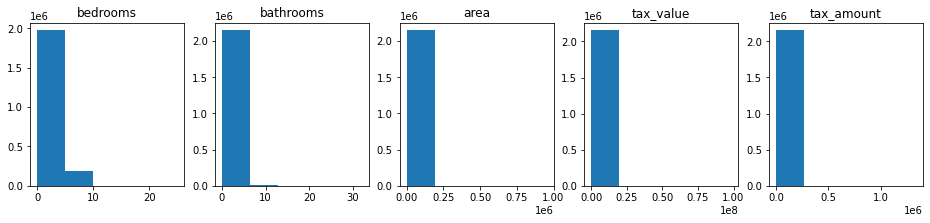

In [65]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
plt.show()

### Boxplots

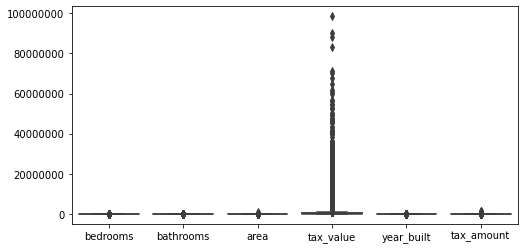

In [38]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['fips']))

plt.show()

## Takeaways for both sets of charts
* A large number of outliers exist in the data and need to be removed

In [67]:
df.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built',
       'tax_amount', 'fips'],
      dtype='object')

In [68]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [75]:
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'tax_amount'])
df

,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,fips
7,3,2,2077,646760,1926,7925,6037
19,3,2,1300,233266,1950,3111,6037
20,3,2,1222,290492,1951,3870,6037
23,3,2,1821,537949,2013,6174,6059
33,2,2,1970,637686,2013,9730,6059
...,...,...,...,...,...,...,...
2152846,4,2,2360,273172,2013,4293,6037
2152851,3,2,2033,641757,2015,10009,6059
2152854,4,2,1987,259913,1955,3176,6059
2152856,3,2,1809,405547,2012,4181,6059


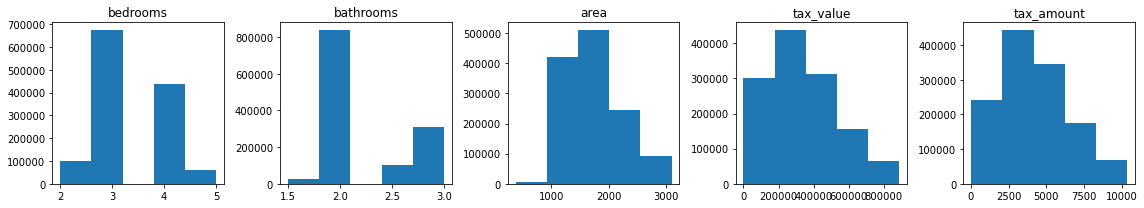

In [72]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
    plt.tight_layout()
    
plt.show()

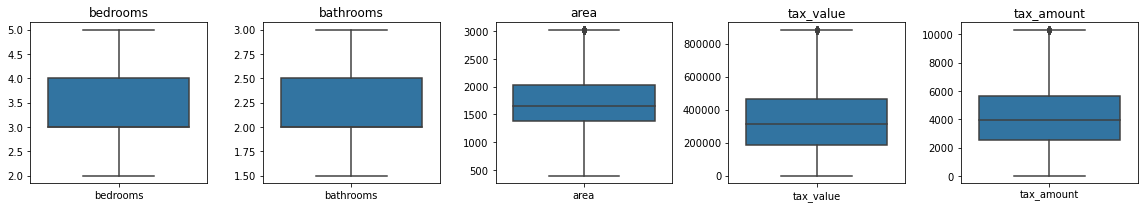

In [79]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'tax_amount']

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()

# Prepare

## Are there any null values?

In [7]:
# get total of null values for each row
df.isnull().sum()

bedrooms        11
bathrooms       11
area          8485
tax_value      493
year_built    9338
taxamount     4442
fips             0
dtype: int64

* dropping rows with nulls in bedroomcnt and bathroomcnt because there are very few of them
* dropping rows with nulls in taxvaluedollorcnt, training the model to asociate data with a calculated column seems dubious

In [8]:
# drop rows that are nulls in bedroomcnt, bathroomcnt, taxvaluedollarcnt
df = df.dropna(subset = ['bedrooms','bathrooms', 'tax_value'])

In [9]:
df.isnull().sum()

bedrooms         0
bathrooms        0
area          8100
tax_value        0
year_built    8959
taxamount     3971
fips             0
dtype: int64

* dropping column taxamount because it contains target leak

In [10]:
# drop taxamount
df = df.drop(columns = 'taxamount')

In [11]:
df.isnull().sum()

bedrooms         0
bathrooms        0
area          8100
tax_value        0
year_built    8959
fips             0
dtype: int64

In [12]:
# consider imputing year built
df.year_built.value_counts()

1955.0    84404
1950.0    71686
1954.0    69161
1953.0    62339
1956.0    61938
          ...  
1879.0        1
1877.0        1
1855.0        1
1874.0        1
1823.0        1
Name: year_built, Length: 153, dtype: int64

* because the number of rows with missing data in yearbuilt is grater than the number of rows with the most frequent value, imputing the data using any one value would significantly skew the data I will therefore drop the rows containing nulls in this column

In [13]:
df = df.dropna(subset = ['year_built'])

df.isnull().sum()

bedrooms        0
bathrooms       0
area          598
tax_value       0
year_built      0
fips            0
dtype: int64

In [14]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe()[['area']]

,area
count,2142803
mean,1863
std,1222
min,1
25%,1257
50%,1623
75%,2208
max,952576


In [15]:
pd.reset_option('display.float_format')

* Given the extream outliers, I plan on imputing calculatedfinishedsquarefeet based on the median once the data is split

## Are the column data types correct?

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143401 entries, 4 to 2152863
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   area        float64
 3   tax_value   float64
 4   year_built  float64
 5   fips        float64
dtypes: float64(6)
memory usage: 114.5 MB


In [17]:
# get value counts and decide on data types
cols = df.columns

for col in cols:
    
    print(col.upper())
    print(df[col].value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()

BEDROOMS
3.0     963850
4.0     633983
2.0     335086
5.0     150778
6.0      25153
1.0      23055
0.0       5097
7.0       4802
8.0       1106
9.0        290
10.0       121
11.0        34
13.0        15
12.0        12
14.0         7
15.0         6
18.0         3
16.0         2
25.0         1
Name: bedrooms, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

BATHROOMS
2.00     943272
3.00     422656
1.00     413782
2.50     142846
4.00      82123
1.50      31166
3.50      28471
5.00      28351
4.50      19476
6.00      10746
5.50       6202
0.00       4950
7.00       4393
8.00       1688
6.50       1330
9.00        712
7.50        382
10.00       325
11.00       145
8.50        108
12.00        73
9.50         50
13.00        39
14.00        25
15.00        17
0.50         16
10.50        14
16.00        12
18.00         8
20.00         6
17.00         4
1.75          3
12.50         3
11.50         3
14.50         1
32.00         1
19.50         1
19.00         1
Name: bathrooms, dtyp

* casting fips and year built as an object because it is a numerical represintation of a catagorical value
* leaving the rest as floats

In [18]:
df.fips = df.fips.astype(object)
df.year_built = df.year_built.astype(object)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143401 entries, 4 to 2152863
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   area        float64
 3   tax_value   float64
 4   year_built  object 
 5   fips        object 
dtypes: float64(4), object(2)
memory usage: 114.5+ MB


## Split the data

In [20]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

## Impute the data

In [21]:
imputer = SimpleImputer(strategy='median')  # build imputer

imputer.fit(train[['area']]) # fit to train

# transform the data
train[['area']] = imputer.transform(train[['area']])
validate[['area']] = imputer.transform(validate[['area']])
test[['area']] = imputer.transform(test[['area']])

In [22]:
train.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
fips          0
dtype: int64

In [23]:
validate.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
fips          0
dtype: int64

In [24]:
test.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
fips          0
dtype: int64

In [25]:
train

,bedrooms,bathrooms,area,tax_value,year_built,fips
1304496,3.0,2.0,1242.0,60625.0,1936.0,6037.0
1232706,2.0,1.0,836.0,52965.0,1949.0,6037.0
1849408,3.0,2.0,3049.0,104973.0,1971.0,6059.0
1879936,4.0,3.0,2635.0,894657.0,1987.0,6037.0
50505,4.0,3.0,2563.0,331065.0,1982.0,6037.0
...,...,...,...,...,...,...
2091693,2.0,1.0,1066.0,25424.0,1921.0,6037.0
1561515,5.0,3.0,3088.0,534598.0,1998.0,6111.0
134013,3.0,1.0,1032.0,295000.0,1924.0,6037.0
1358019,3.0,2.0,1591.0,457000.0,1967.0,6037.0


In [26]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
train.describe()

,bedrooms,bathrooms,area,tax_value
count,1200304,1200304,1200304,1200304
mean,3,2,1863,461730
std,1,1,1303,696377
min,0,0,1,1
25%,3,2,1257,189150
50%,3,2,1623,328471
75%,4,3,2207,534297
max,18,32,952576,90188462


In [27]:
##################################################Wrangle.py###################################################

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from env import user, password, host

#**************************************************Acquire*******************************************************

def acquire_zillow():
    
    url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
    query = """
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017

    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")"""

    # get dataframe of data
    df = pd.read_sql(query, url)
    
    
    # renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built',
                              'taxamount':'tax_amount'})
    return df

#**************************************************Distributions*******************************************************

def get_hist(df):
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)
        
        
def get_box(df):
    
    plt.figure(figsize=(8,4))

    sns.boxplot(data=df.drop(columns=['fips', 'year_built']))
    plt.show()
        
#**************************************************Prepare*******************************************************

def prepare_zillow(df):
    
    # drop rows that are nulls 
    df = df.dropna(subset = ['bedrooms','bathrooms', 'year_built', 'tax_value'])
    
    # drop taxamount
    df = df.drop(columns = 'tax_amount')
    
    # converting column datatypes
    df.fips = df.fips.astype(str)
    df.year_built = df.year_built.astype(str)
    df.bedrooms = df.bedrooms.astype(int)
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute median value 
    imputer = SimpleImputer(strategy='median') 

    imputer.fit(train[['area']])

    train[['area']] = imputer.transform(train[['area']])        
    validate[['area']] = imputer.transform(validate[['area']])  
    test[['area']] = imputer.transform(test[['area']])          
    
    return train, validate, test    

#**************************************************Wrangle*******************************************************

def wrangle_zillow():
    
    train, validate, test = prepare_zillow(acquire_zillow())
    
    return train, validate, test

# Formal Notebook

**A formal notebook should show the what and the why...Import the how.**

# Imports

In [28]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

from env import user, password, host
import wrangle_exercise as w

# Acquire

* Data acquired from Zillow database
* Query selected single unit properties observed in 2017
* Dataframe contained aprox. 2 million rows and 7 columns
* Renamed some of the columns

In [29]:
df = w.acquire_zillow()

## Veriable Distributions

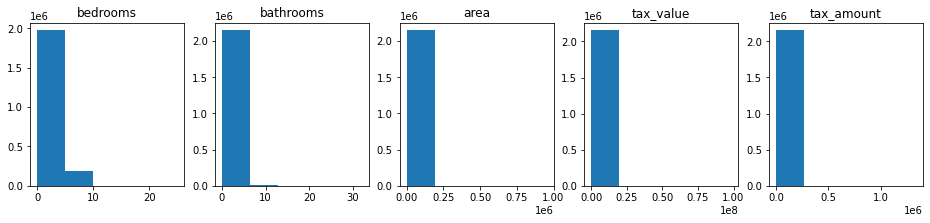

In [30]:
w.get_hist(df)

* Takeaways

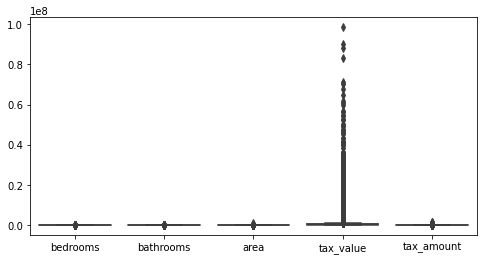

In [31]:
w.get_box(df)

* Takeaways

# Prepare
* dropped rows with nulls in bedrooms and bathrooms because very fer lines were effected
* dropped rows with nulls in year_built because imputing could skew the data due to the large number of rows containing nulls in that column
* dropped rows with nulls in tax_value imputing the target variable seems dubious
* dropped tax_ammount as it likely contains target leak. You must first know the tax_value of a property before you can calculate the correct tax ammount. Because we are predicting tax_value we will not know what the tax_amount is untill after the model has made it's predictions
* final shape of dataframe before split, 2 million rows and 6 columns
* split data into train, validate, and test dataframes
* imputed area using the median of train

In [32]:
train, validate, test = w.prepare_zillow(df)

In [33]:
train

,bedrooms,bathrooms,area,tax_value,year_built,fips
1304496,3,2,1242,60625,1936.0,6037.0
1232706,2,1,836,52965,1949.0,6037.0
1849408,3,2,3049,104973,1971.0,6059.0
1879936,4,3,2635,894657,1987.0,6037.0
50505,4,3,2563,331065,1982.0,6037.0
...,...,...,...,...,...,...
2091693,2,1,1066,25424,1921.0,6037.0
1561515,5,3,3088,534598,1998.0,6111.0
134013,3,1,1032,295000,1924.0,6037.0
1358019,3,2,1591,457000,1967.0,6037.0
